In [1]:
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import cv2
import os
import numpy as np
import pandas as pd


path_train = r"D:\DIODE\train\outdoor"

filelist_train = []

for root, dirs, files in os.walk(path_train):
    for file in files:
        filelist_train.append(os.path.join(root, file))

filelist_train.sort()
data_train = {
    "image": [x for x in filelist_train if x.endswith(".png")],
    "depth": [x for x in filelist_train if x.endswith("_depth.npy")],
    "mask": [x for x in filelist_train if x.endswith("_depth_mask.npy")],
}
df_train = pd.DataFrame(data_train)

df_train = df_train.sample(frac=1, random_state=42)



path_val = r"D:\DIODE\val\outdoor"

filelist_val = []

for root, dirs, files in os.walk(path_val):
    for file in files:
        filelist_val.append(os.path.join(root, file))

filelist_val.sort()
data_val = {
    "image": [x for x in filelist_val if x.endswith(".png")],
    "depth": [x for x in filelist_val if x.endswith("_depth.npy")],
    "mask": [x for x in filelist_val if x.endswith("_depth_mask.npy")],
}
df_val = pd.DataFrame(data_val)

df_val = df_val.sample(frac=1, random_state=42)


class DepthDataSequence(Sequence):
    def __init__(self, df, batch_size, crop_size):
        self.df = df
        self.batch_size = batch_size
        self.crop_height, self.crop_width = crop_size

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch = self.df[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        depths = []
        min_depth = 1e-3  # Adjust this value based on your specific requirements
        for _, row in batch.iterrows():
            # Load image, crop it, and normalize it to be in range [0, 1]
            img = cv2.imread(row['image'])
            h, w = img.shape[:2]
            j = (h - self.crop_height) // 2
            i = (w - self.crop_width) // 2
            img = img[j:j + self.crop_height, i:i + self.crop_width] / 255.0

            # Load depth map and take the depth value at the center
            depth = np.load(row['depth'])
            depth = depth[j:j + self.crop_height, i:i + self.crop_width]
            center_depth = depth[depth.shape[0] // 2, depth.shape[1] // 2] / 10.0

            # If center_depth is zero or less than the minimum acceptable depth, skip this image
            if center_depth < min_depth:
                continue

            images.append(img)
            depths.append(center_depth)
            #print(center_depth)

        return np.array(images), np.array(depths)


In [2]:
len(df_train)

16884

In [3]:
crop_size = (200, 600)  # height, width
batch_size = 32
train_gen = DepthDataSequence(df_train[:1000], batch_size, crop_size)
val_gen = DepthDataSequence(df_train[1000:1400], batch_size, crop_size)


In [6]:
from tensorflow.keras.applications import VGG16

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers

def create_model():
    # Load the VGG16 network, ensuring the head FC layer sets are left off
    vgg = VGG16(weights="imagenet", include_top=False, input_shape=(200, 600, 3))

    # Freeze all layers in the VGG16 so that they will not be updated during the first training process
    vgg.trainable = False

    model = Sequential()
    # Add the VGG16 model
    model.add(vgg)
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
    model.add(Dense(1))

    return model


In [7]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002,
    amsgrad=False,
)

model = create_model()

model.compile(optimizer, loss='mean_squared_error')

history = model.fit(train_gen, validation_data=val_gen, epochs=20)

Epoch 1/20
32/32 [==============================] - 58s 2s/step - loss: 13.5417 - val_loss: 7.7373
Epoch 2/20
32/32 [==============================] - 28s 881ms/step - loss: 7.1532 - val_loss: 5.8503
Epoch 3/20
32/32 [==============================] - 28s 888ms/step - loss: 5.5499 - val_loss: 5.1354
Epoch 4/20
32/32 [==============================] - 28s 878ms/step - loss: 4.5665 - val_loss: 4.9094
Epoch 5/20
32/32 [==============================] - 28s 884ms/step - loss: 3.8570 - val_loss: 4.3813
Epoch 6/20
32/32 [==============================] - 28s 889ms/step - loss: 3.2880 - val_loss: 4.2319
Epoch 7/20
32/32 [==============================] - 28s 876ms/step - loss: 2.8730 - val_loss: 4.1469
Epoch 8/20
32/32 [==============================] - 28s 881ms/step - loss: 2.5575 - val_loss: 4.2076
Epoch 9/20
32/32 [==============================] - 29s 896ms/step - loss: 2.5105 - val_loss: 3.9681
Epoch 10/20
32/32 [==============================] - 28s 875ms/step - loss: 2.1409 - val_loss

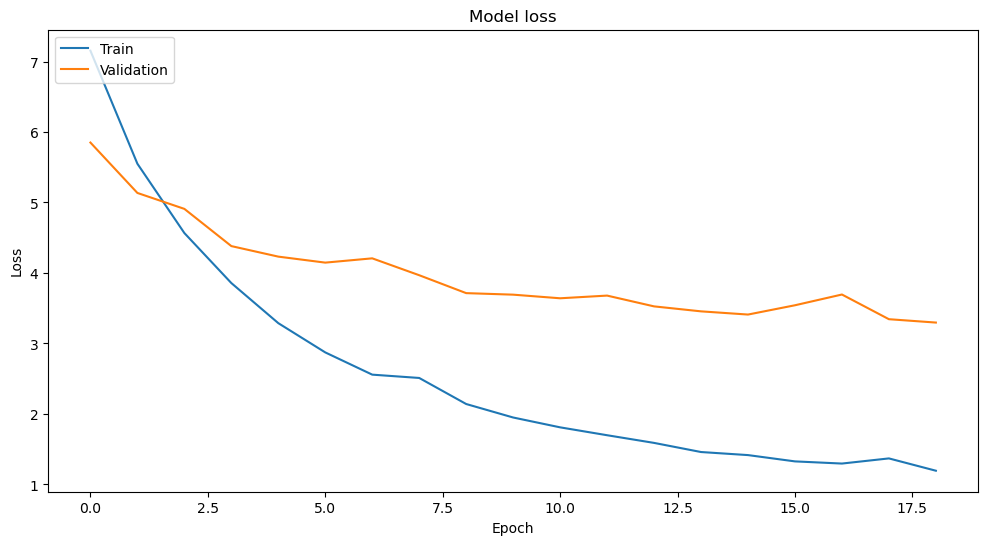

In [8]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#Fine-Tuning
from tensorflow.keras.optimizers import Adam

# Unfreeze the last few layers
for layer in model.layers[0].layers[-1:]:
    layer.trainable = True

# Recompile the model for the changes to take effect
# We use a lower learning rate for fine-tuning
model.compile(optimizer=Adam(lr=1e-5), loss='mean_squared_error')

# Retrain the model
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

C:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
32/32 [==============================] - 30s 915ms/step - loss: 1.0587 - val_loss: 3.2583
Epoch 2/10
32/32 [==============================] - 28s 889ms/step - loss: 1.0037 - val_loss: 3.2079
Epoch 3/10
32/32 [==============================] - 29s 916ms/step - loss: 0.9597 - val_loss: 3.1653
Epoch 4/10
32/32 [==============================] - 28s 884ms/step - loss: 0.9186 - val_loss: 3.1410
Epoch 5/10
32/32 [==============================] - 28s 884ms/step - loss: 0.8922 - val_loss: 3.1150
Epoch 6/10
32/32 [==============================] - 28s 893ms/step - loss: 0.8761 - val_loss: 3.0950
Epoch 7/10
32/32 [==============================] - 28s 886ms/step - loss: 0.8414 - val_loss: 3.0806
Epoch 8/10
32/32 [==============================] - 28s 891ms/step - loss: 0.8271 - val_loss: 3.0658
Epoch 9/10
30/32 [===========================>..] - ETA: 1s - loss: 0.8049

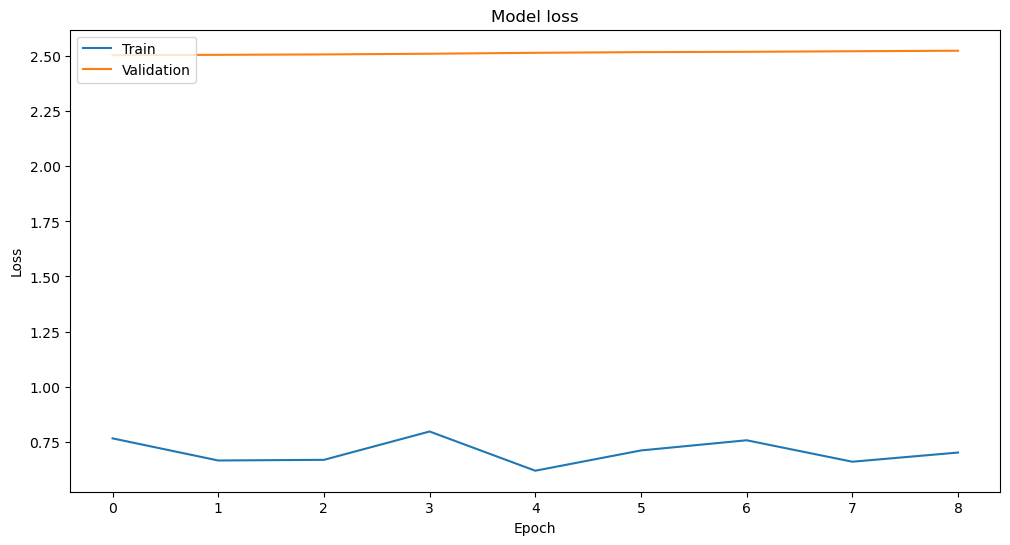

In [20]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting the distances on the validation set
val_predictions = model.predict(val_gen)

# Reshaping predictions and true values to one-dimensional arrays
val_predictions = val_predictions.reshape(-1)

# We need to collect the true values from the generator
true_values = []
for _, batch_depths in val_gen:
    true_values.extend(batch_depths)

true_values = np.array(true_values).reshape(-1)

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values, val_predictions)
print(f"Mean Absolute Error (MAE): {mae} meters (normalized)")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, val_predictions)
print(f"Mean Squared Error (MSE): {mse} meters (normalized)")

13/13 [==============================] - 8s 624ms/step
Mean Absolute Error (MAE): 0.8062759041786194 meters (normalized)
Mean Squared Error (MSE): 2.21272611618042 meters (normalized)


In [23]:
# De-normalize the predictions and true values
val_predictions_denorm = val_predictions * 10
true_values_denorm = true_values * 10

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values_denorm, val_predictions_denorm)
print(f"Mean Absolute Error (MAE): {mae} meters")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values_denorm, val_predictions_denorm)
print(f"Mean Squared Error (MSE): {mse} meters")

Mean Absolute Error (MAE): 8.062758445739746 meters
Mean Squared Error (MSE): 221.27261352539062 meters


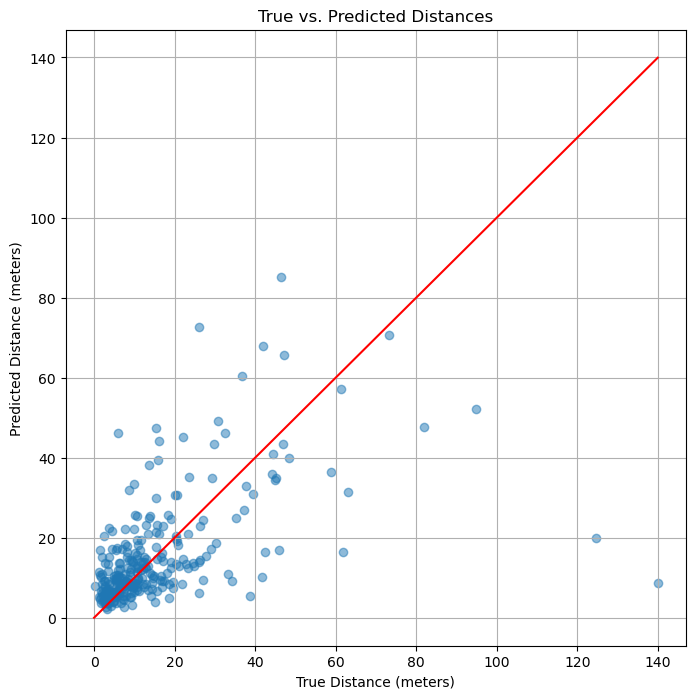

In [24]:
import matplotlib.pyplot as plt

# Scatter plot of true vs. predicted distances
plt.figure(figsize=(8, 8))
plt.scatter(true_values_denorm, val_predictions_denorm, alpha=0.5)
plt.plot([0, max(true_values_denorm)], [0, max(true_values_denorm)], color='red')  # Ideal model would follow this line
plt.xlabel('True Distance (meters)')
plt.ylabel('Predicted Distance (meters)')
plt.title('True vs. Predicted Distances')
plt.grid(True)
plt.show()